In [1]:
from pathlib import Path

import matplotlib
from matplotlib.cm import get_cmap
from matplotlib.lines import Line2D
import matplotlib.text as mtext
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

In [2]:
DATA_ROOT = Path('..') / 'data'

In [3]:
dfs = []
activities = ['bed', 'chair', 'lying', 'ambulating']
default_names = ['time', 'front', 'vertical', 'lateral', 'sensor_id', 'rssi', 'phase', 'frequency', 'activity']
for data_file in Path(DATA_ROOT).rglob('d[12]p??[FM]'):
    df = pd.read_csv(data_file, names=default_names)
    df['activity_label'] = df['activity'].apply(lambda i: activities[i - 1])
    df['gender_label'] = str(data_file)[-1]
    df['participant'] = data_file.name
    dfs.append(df)

activity_df = pd.concat(dfs, axis='index')
activity_df.to_csv('activity_df.csv')

In [67]:
def get_activity_times(df):
    
    # Sort by time just in case...
    df = df.sort_values(by=['time'])
    d = df['activity']
    
    # This gets the start index of each activity
    #
    # The shift method just shifts the series along 1.
    #
    #   d = pd.Series([1., 1., 2., 2.])
    #   np.where(d != d.shift(1))[0] # <- array([0, 2])
    #
    starts = np.where(d != d.shift(1))[0]
    
    # This gets the end index of each activity
    #
    #   d = pd.Series([1., 1., 2., 2.])
    #   np.where(d != d.shift(-1))[0] # <- array([1, 3])
    #
    ends = np.where(d != d.shift(-1))[0]
    
    # So now we can just iterate over the start and end indices.
    bounds = []
    for start, end in zip(starts, ends):
         bounds.append({
            'activity': df['activity'][start], 
            'activity_label': df['activity_label'][start], 
            'start_index': start, 
            'end_index': end,
            'start_time': df['time'][start],
            'end_time': df['time'][end],
            'duration': df['time'][end] - df['time'][start]
        })
    return pd.DataFrame(bounds)

In [68]:
def get_participant_activity_times(df):
    times_df = get_activity_times(df)
    times_df['participant'] = df['participant']
    return times_df

activity_times_df = activity_df.groupby(
    ['participant']).apply(get_participant_activity_times).reset_index(drop=True)

In [69]:
activity_times_df.head()

,activity,activity_label,start_index,end_index,start_time,end_time,duration,participant
0,1,bed,0,54,0.00,37.00,37.00,d1p01M
1,3,lying,55,171,37.75,74.25,36.50,d1p01M
2,1,bed,172,218,76.00,103.25,27.25,d1p01M
3,4,ambulating,219,222,104.00,111.50,7.50,d1p01M
4,2,chair,223,282,116.00,193.00,77.00,d1p01M


In [44]:
participant = activity_df['participant'].unique()[0]

In [51]:
ddf = activity_df[activity_df['participant'] == participant]
adf = sub_df[sub_df['participant'] == participant].reset_index(drop=True)

In [57]:
len(sub_df)

157

In [55]:
ddf

,time,front,vertical,lateral,sensor_id,rssi,phase,frequency,activity,activity_label,gender_label,participant
0,0.00,1.034200,0.388130,-0.013684,4,-59.5,4.43010,920.75,1,bed,F,d1p57F
1,1.00,0.987280,0.215880,0.088944,4,-65.0,5.84600,923.25,3,lying,F,d1p57F
2,1.25,0.987280,-0.002297,-0.139120,4,-67.0,5.81230,922.25,3,lying,F,d1p57F
3,2.25,0.858300,0.169950,0.043332,3,-48.0,0.24390,921.25,3,lying,F,d1p57F
4,2.30,0.858300,0.169950,0.043332,3,-50.5,1.06000,925.25,3,lying,F,d1p57F
...,...,...,...,...,...,...,...,...,...,...,...,...
452,267.63,0.705870,0.652240,0.362620,1,-61.0,4.22920,921.25,4,ambulating,F,d1p57F
453,268.50,0.014071,1.157500,-0.036490,4,-51.5,6.27400,920.25,4,ambulating,F,d1p57F
454,268.60,0.014071,1.157500,-0.036490,3,-65.0,1.20420,920.25,4,ambulating,F,d1p57F
455,269.00,0.143050,0.985260,-0.059296,4,-57.0,0.25157,924.75,4,ambulating,F,d1p57F


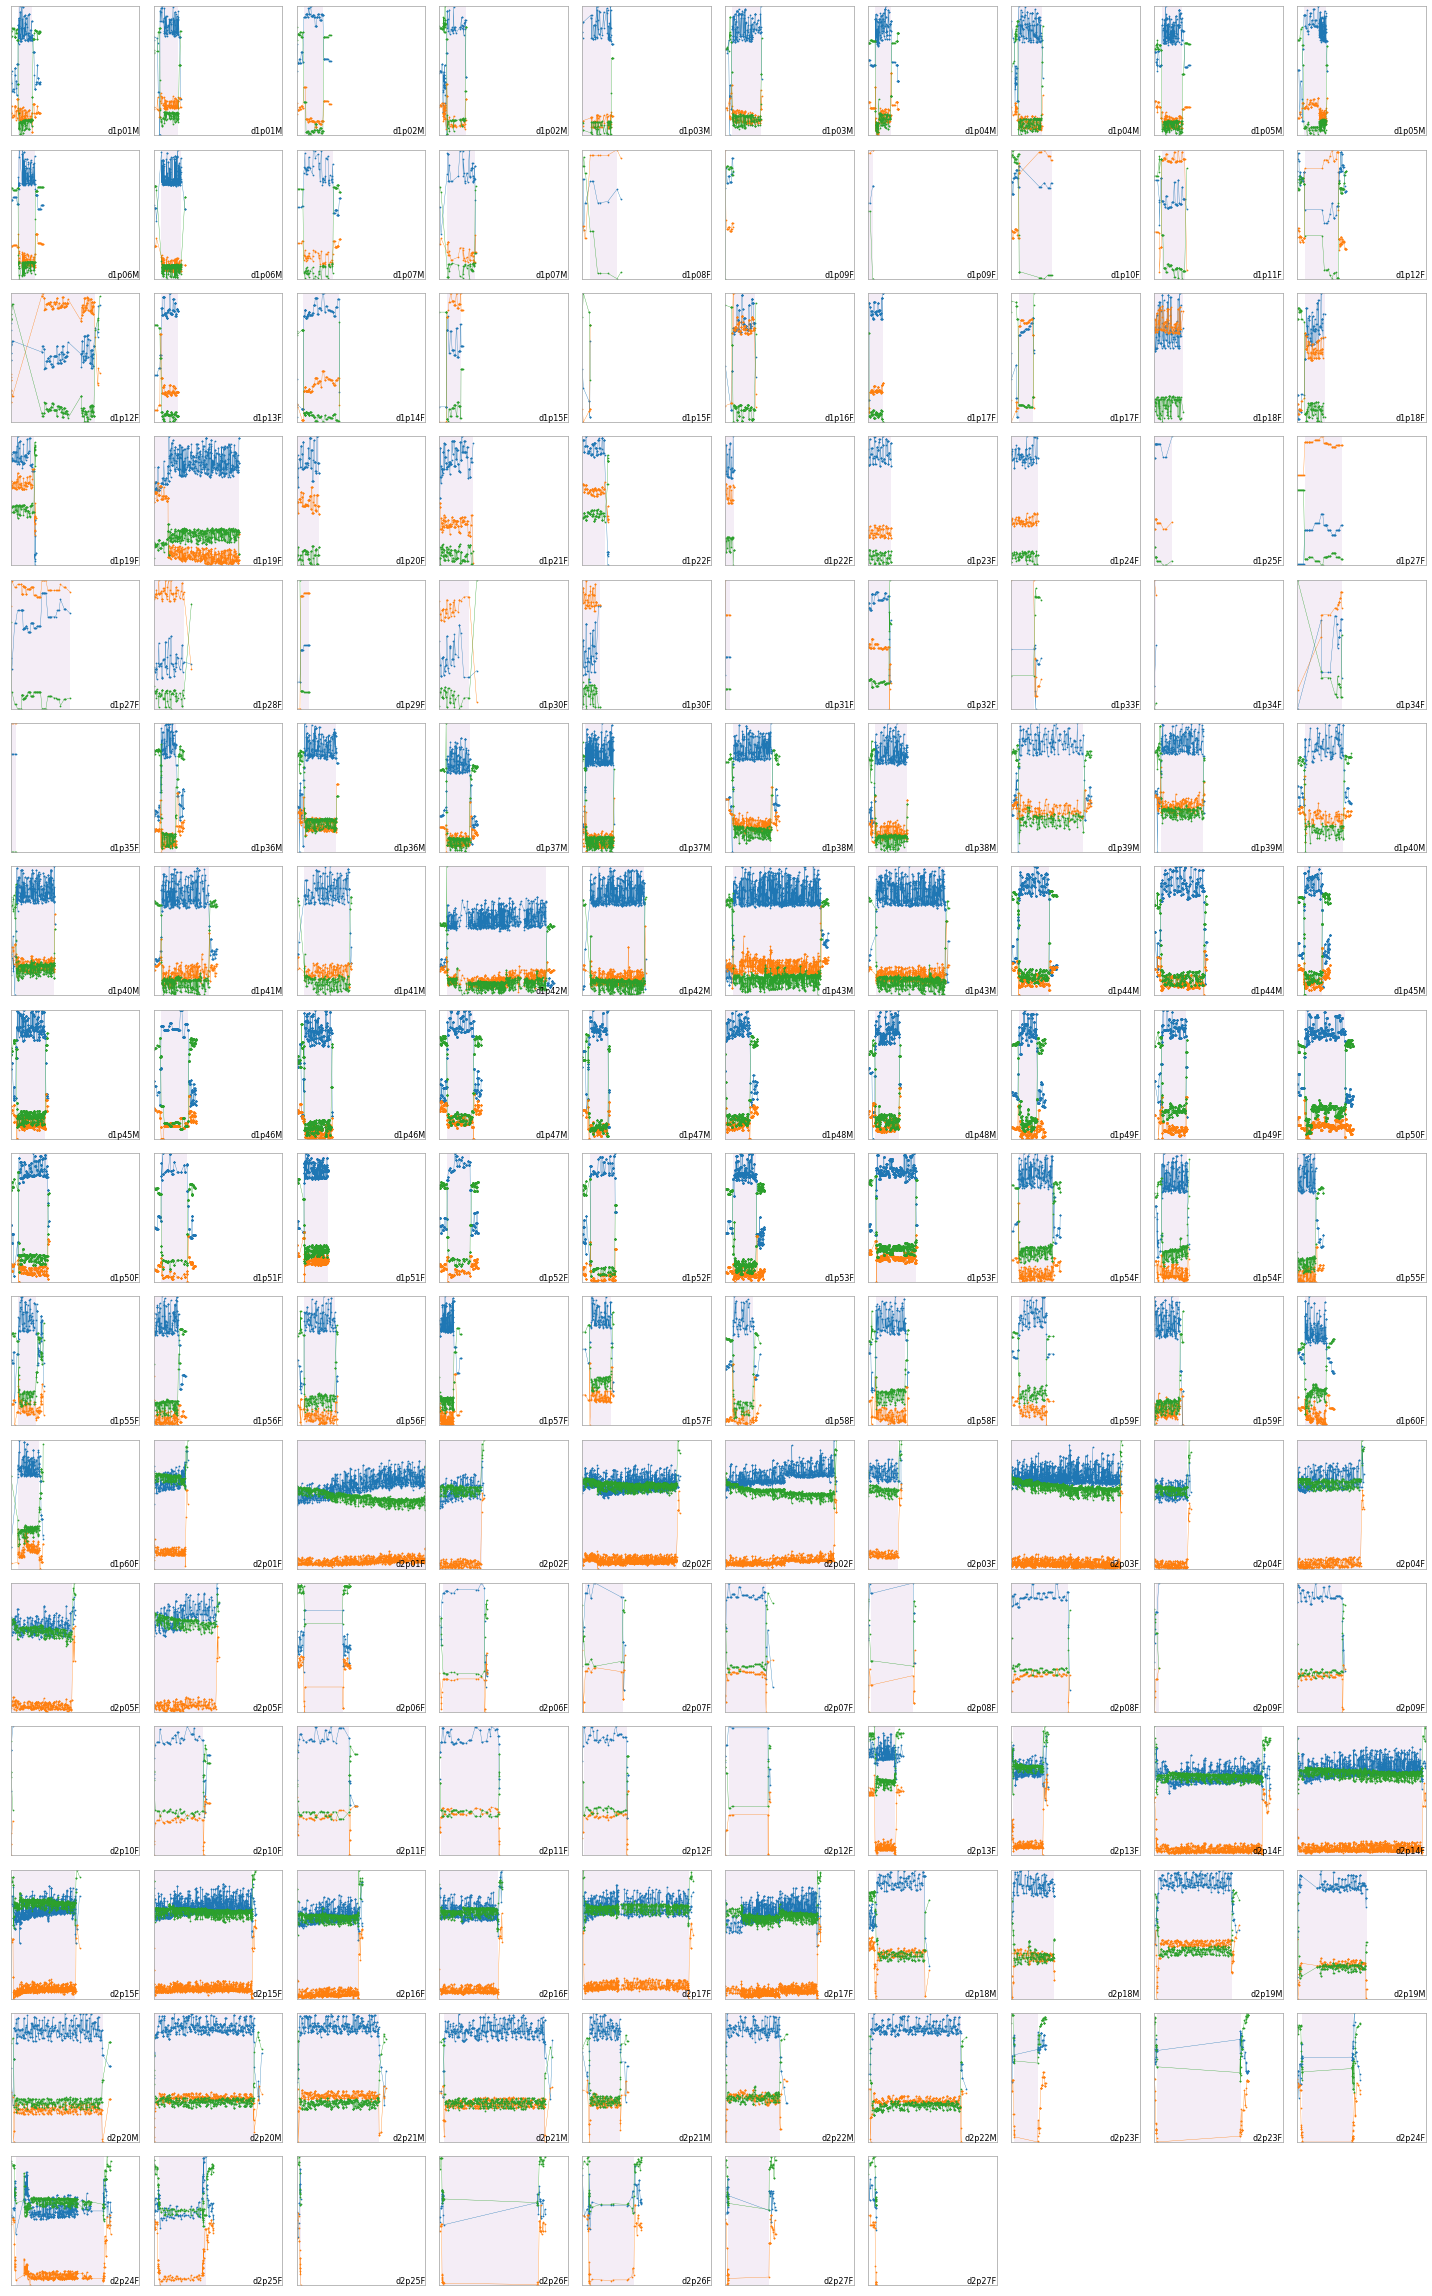

In [89]:
matplotlib.rc('axes', edgecolor='#aaaaaa')

# Rectangle colors
rect_colors = get_cmap('Pastel1').colors

# Line colors
line_colors = get_cmap('tab10').colors

# Common line options
line_opts = dict(linewidth=0.333, marker='.', markersize=1.5)

# define number of plots per row
ncols = 10
nrows = np.ceil(len(sub_df) / ncols).astype(int)

columns = ['front', 'lateral', 'vertical']
offset = 20
# Create figure
fig = plt.figure(figsize=(ncols * 2, nrows * 2))

window_df = activity_times_df[activity_times_df['activity_label'] == 'lying'].reset_index(drop=True)
max_duration = window_df['duration'].max()
for index, row in window_df.iterrows():
    
    ax = plt.subplot(nrows, ncols, index + 1)
    # Tidy the axis up a bit
    ax.set_xticks([])
    ax.set_yticks([])
    ax.margins(0, 0, tight=True)
    ax.set_xlim((0, max_duration))
    plot_df = activity_df[
        (activity_df['participant'] == row['participant']) &
        (activity_df['time'] >= row['start_time'] - offset) & 
        (activity_df['time'] <= row['end_time'] + offset)]
    
    ymin, ymax = plot_df[columns].min().min(), plot_df[columns].max().max()
    for j, column in enumerate(columns):
        t = plot_df['time'] - plot_df['time'].min()
        ax.plot(t, plot_df[column], color=line_colors[j], **line_opts)
    
    x = row['start_time'] - plot_df['time'].min()
    y = ymin
    height = ymax - ymin
    duration = row['duration']
    rect = mpatches.Rectangle(
        [x, y], 
        duration, 
        height, 
        alpha=0.333, 
        color=rect_colors[row['activity']], 
        linewidth=0, 
        zorder=1)
    ax.add_patch(rect)
            
    ax.text(
        max_duration, 
        plot_df[columns].min().min(), 
        row['participant'],
        fontsize=8, 
        ha='right', 
        va='bottom')

fig.patch.set_facecolor('#fff')
plt.subplots_adjust(wspace=0, hspace=0)
plt.tight_layout()
plt.savefig('lying.png')